## What to expect as an Airbnb Host in Berlin

Airbnb has successfully disrupted the traditional hospitality industry as more and more travellers decide to use Airbnb as their premier accommodation provider. Since its inception in 2008, Airbnb has seen an enormous growth with the number of rentals listed on its website growing exponentially each year.

In Germany, no city is more popular than Berlin, the capital at the river Spree. That implies, Berlin is one of the hottest markets for Airbnb in Europe, with over 22,552 listings as of November 2018. With a size of 891 km², this means there are roughly 25 homes being rented out per km² in Berlin on Airbnb!

Considerung the possibility I would have to relocate for a new data science job but want to keep my current flat in Berlin (which is quite cheap!) , I would wonder if it is worth to offer my jewel on Airbnb. Could this perhaps be a profitable option? However, for potential hosts it is difficult to know what the true value of their home is and how much their home might be damanded. And is there anything else a host can influence other than location and furniture, which are obviously often fixed - such as description, communication patterns, services to boost their earnings?

The following three questions will drive this project:

> **1. Can we recommend a fairly spot-on daily price for a new accommodation that fits into its specific market environment and competitors in Berlin?** <br>
> **2. How big is the demand likely to be? What can a host expect with respect to occupancy and earnings here in Berlin? And what does the demand depend on?** <br>
> **3. And lastly: What do visitors like and dislike?**

The **first question** focuses on the accommodation features and initial presentation decisions a new host can make: i.e. whether to picture herself/himself at the website, how many minimum nights, whether to offer instant bookings etc. A machine learning algorithm will be applied to try to get an answer. **The second question** is similar and even stronger focuses on geography to explain the demand, but will use mainly visualizations to narrow down the search for answers. However, the **last question** processes the reviews to find out what people prefer and reject. Natural Language Processing (NLP) and specifically Sentiment Analysis are what we make use of here.

To not prevent my notebook(s) from ever being read by their very length, I wrote one "paper", aka notebook, for each question. The first notebook can be found here (**Insert Link!!!!**) and the second one here (**Insert Link!!!!**).

### The datasets

In the third and last notebook, I will use the reviews data and combine it with some features from the detailed listings data for Berlin sourced from the Inside Airbnb website. Both datasets were scraped 07 Nov 2018. Hopefully we will find out the visitors' wants and needs.

## > No. 3 _ Understanding Visitors' Wants and Needs
<a id='Table of contents'></a>

### <a href='#1. Obtaining and Viewing the Data'> 1. Obtaining and Viewing the Data </a>

### <a href='#2. Preprocessing the Data'> 2. Preprocessing the Data </a>
* <a href='#2.1. Dealing with Missing Values'> 2.1. Dealing with Missing Values </a>
* <a href='#2.2. Language Detection'> 2.2. Language Detection </a>

### <a href='#3. Visualizing the Data'> 3. Visualizing the Data </a>
* <a href='#3.1. WordClouds'> 3.1. WordClouds </a>

### <a href='#4. Sentiment Analysis'> 4. Sentiment Analysis </a>
* <a href='#4.1. Preparing Target and Features'> 4.1. Preparing Target and Features </a>
* <a href='#4.2. Splitting and Scaling the Data'> 4.2. Splitting and Scaling the Data </a>
* <a href='#4.3. Training an XGBoost Regressor'> 4.3. Training an XGBoost Regressor </a>

### <a href='#5. Interpreting the Data'> 5. Interpreting the Data </a>

### <a href='#6. Appendix'> 6. Appendix </a>

### 1. Obtaining and Viewing the Data 
<a id='1. Obtaining and Viewing the Data'></a>

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import time
import datetime

In [2]:
df_1 = pd.read_csv('data/insideAirbnb/reviews.csv.gz')

# checking shape ...
print("The dataset has {} rows and {} columns.".format(*df_1.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_1.duplicated().sum()))

The dataset has 401963 rows and 6 columns.
It contains 0 duplicates.


In [3]:
df_1.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ..."
4,2015,74293504,2016-05-14,10414887,Romina,"Buena ubicación, el departamento no está orden..."


It may be valueable to have more information such as the latitude and longitude, the host id, the neighbourhood etc. To get this information, let's **combine our reviews_dataframe with the listings_dataframe** and take only the columns in need from the latter one:

In [4]:
df_2 = pd.read_csv('data/insideAirbnb/listings.csv.gz')

# merging my full df_1 + add only the cleaning fee in df_2
df = pd.merge(df_1, df_2[['neighbourhood_group_cleansed', 'host_id', 'latitude',
                          'longitude', 'number_of_reviews', 'id', 'property_type']], 
              left_on='listing_id', right_on='id', how='left')

df.rename(columns = {'id_x':'id', 'neighbourhood_group_cleansed':'neighbourhood_group'}, inplace=True)
df.drop(['id_y'], axis=1, inplace=True)

In [5]:
df.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...,Mitte,2217,52.534537,13.402557,118,Guesthouse
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse
2,2015,71605267,2016-04-26,30048708,Victor,Un appartement tres bien situé dans un quartie...,Mitte,2217,52.534537,13.402557,118,Guesthouse


In [6]:
# checking shape
print("The dataset has {} rows and {} columns.".format(*df.shape))

The dataset has 401963 rows and 12 columns.


By the way, I would be interested to find out if at least some private hosts started to run a professional business with Airbnb - at least this is told by the press. To work this out, let's first drop all genuine professional businesses such as hotels and hotels:

In [8]:
#df.property_type.value_counts()

In [9]:
#df.drop(df[(df.property_type == 'Hostel') | (df.property_type == 'Boutique hotel') | (df.property_type == 'Hotel')].index, 
        #axis=0, inplace=True)

In [10]:
# group by hosts and count the number of unique listings --> cast it to a dataframe
prop_per_host = pd.DataFrame(df.groupby('host_id')['listing_id'].nunique())

# sort unique values descending and show the Top20
prop_per_host.sort_values(by=['listing_id'], ascending=False, inplace=True)
prop_per_host.head(20)

,listing_id
host_id,
1625771,44
8250486,38
2293972,28
59442407,19
87442687,16
54942921,16
8912086,15
34705166,15
79430806,15


Let's go in for a closer look at the Top 3 hosts. How many properties do they have in the different areas?

In [11]:
criterium = df.host_id == 1625771
df[criterium].neighbourhood_group.value_counts()
df[criterium].groupby('neighbourhood_group')['listing_id'].nunique()

neighbourhood_group
Charlottenburg-Wilm.         3
Friedrichshain-Kreuzberg     2
Lichtenberg                  1
Mitte                       10
Neukölln                     1
Pankow                      19
Tempelhof - Schöneberg       7
Treptow - Köpenick           1
Name: listing_id, dtype: int64

In [12]:
criterium = df.host_id == 8250486
df[criterium].neighbourhood_group.value_counts()
df[criterium].groupby('neighbourhood_group')['listing_id'].nunique()

neighbourhood_group
Friedrichshain-Kreuzberg     1
Mitte                       37
Name: listing_id, dtype: int64

In [13]:
criterium = df.host_id == 2293972
df[criterium].neighbourhood_group.value_counts()
df[criterium].groupby('neighbourhood_group')['listing_id'].nunique()

neighbourhood_group
Friedrichshain-Kreuzberg    24
Lichtenberg                  4
Name: listing_id, dtype: int64

At the least host 1625771 has deeply diversified into different neighbourhoods...

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 2. Preprocessing the Data 
<a id='2. Preprocessing the Data'></a>

#### 2.1. Dealing with Missing Values
<a id='2.1. Dealing with Missing Values'></a>

In [14]:
df.isna().sum()

listing_id               0
id                       0
date                     0
reviewer_id              0
reviewer_name            0
comments               496
neighbourhood_group      0
host_id                  0
latitude                 0
longitude                0
number_of_reviews        0
property_type            0
dtype: int64

In [15]:
df.dropna(inplace=True)
df.isna().sum()

listing_id             0
id                     0
date                   0
reviewer_id            0
reviewer_name          0
comments               0
neighbourhood_group    0
host_id                0
latitude               0
longitude              0
number_of_reviews      0
property_type          0
dtype: int64

In [16]:
df.shape

(401467, 12)

*Back to: <a href='#Table of contents'> Table of contents</a>*
#### 2.2. Language Detection
<a id='2.2. Language Detection'></a>

In [17]:
from langdetect import detect

In [81]:
# write the function that detects the language
def language_detection(text):
    try:
        return detect(text)
    except:
        return None

In [19]:
# calculate the time it needs to run the function
start = datetime.datetime.now()

df['language'] = df['comments'].apply(language_detection)

finish = datetime.datetime.now()
elapsed = finish - start
print('Time Elapsed:', elapsed)

In [20]:
#finish = datetime.datetime.now()
#elapsed = finish - start
#print('Time Elapsed:', elapsed)

Time Elapsed: 0:44:04.885171


In [21]:
df.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type,language
0,2015,69544350,2016-04-11,7178145,Rahel,Mein Freund und ich hatten gute gemütliche vie...,Mitte,2217,52.534537,13.402557,118,Guesthouse,de
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse,en


In [22]:
# write the dataframe to a csv file in order to avoid 44 minutes ...
# ... language detection when restarting the kernel
df.to_csv('data/processed_df', index=False)

In [4]:
df = pd.read_csv('data/processed_df')

In [5]:
df.language.value_counts().head(10)

en    271836
de     77183
fr     16862
es     12160
it      4863
nl      3891
ru      2306
ko      1641
pt      1398
da      1372
Name: language, dtype: int64

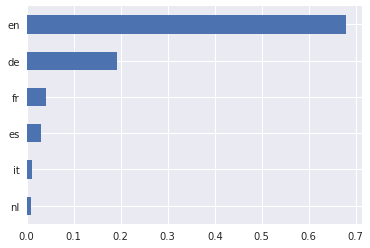

In [6]:
# visualizing the comments' languages "quick and dirty"
ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh');

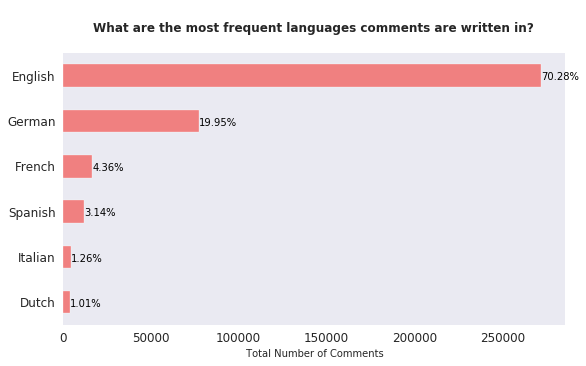

In [7]:
# visualizing the comments' languages "slowly and nice"
sns.set_style('whitegrid')
sns.despine()

ax = df.language.value_counts().head(6).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nWhat are the most frequent languages comments are written in?\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width(), i.get_y()+.35, 
            str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=10, color='black')

# invert for largest on top 
ax.invert_yaxis()

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 3. Visualizing the Data
<a id='3. Visualizing the Data'></a>

#### 3.1. WordClouds
<a id='3.1. WordClouds'></a>

**Preparing Steps**

In [8]:
# import necessary libraries
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image

import re
import string

In [9]:
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(12, 9))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(language + ' Comments\n', fontweight='bold')
    plt.show()

In [10]:
# splitting the dataframes in language related sub dataframes
df_eng = df[(df['language']=='en')]
df_de  = df[(df['language']=='de')]
df_fr  = df[(df['language']=='fr')]

In [11]:
# prepare a mask
mask_1 = np.array(Image.open("images/images_berlin.png"))
#mask_1

In [12]:
# values of 255 are pure white, whereas values of 1 are black
# use the transform_format() function to swap number 1 to 255
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

In [13]:
# Transform your mask into a new one that will work with the function:
transformed_mask_1 = np.ndarray((mask_1.shape[0], mask_1.shape[1]), np.int32)

for i in range(len(mask_1)):
    transformed_mask_1[i] = list(map(transform_format, mask_1[i]))
    
# Check the expected result of your mask
#transformed_mask_1

**Several WordClouds**

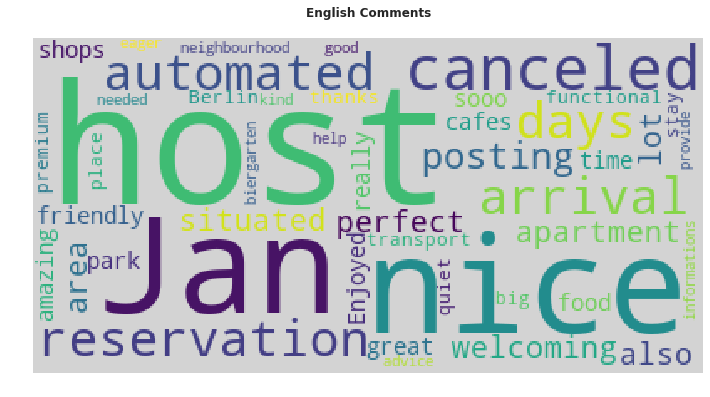

In [14]:
wordcloud = WordCloud(max_font_size=100, max_words=150, background_color="lightgrey", relative_scaling=0.5,
                      stopwords = stopwords.words('english')).generate(str(df_eng.comments.values))

plot_wordcloud(wordcloud, 'English')

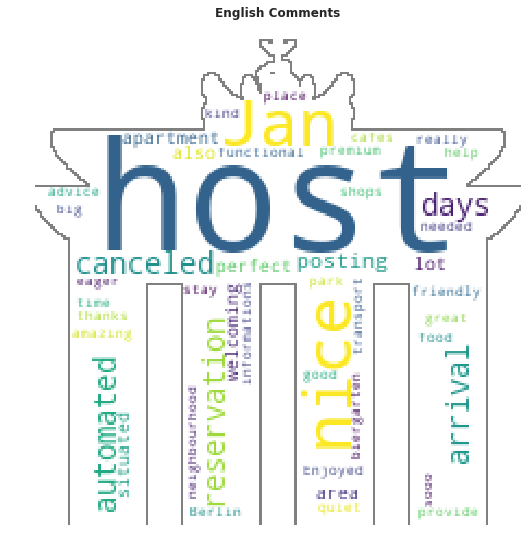

In [15]:
wordcloud = WordCloud(max_font_size=100, max_words=150, background_color="white",
                      stopwords = stopwords.words('english'), mask=transformed_mask_1,
                      contour_width=0.5, contour_color='grey').generate(str(df_eng.comments.values))

plot_wordcloud(wordcloud, 'English')

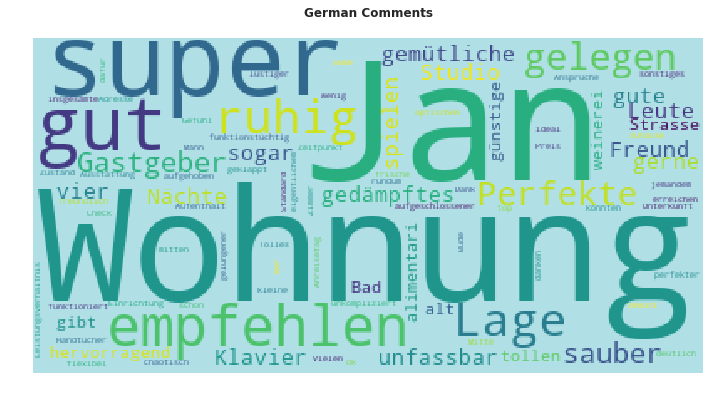

In [16]:
wordcloud = WordCloud(max_font_size=100, max_words=150, background_color="powderblue",
                      stopwords = stopwords.words('german')).generate(str(df_de.comments.values))

plot_wordcloud(wordcloud, 'German')

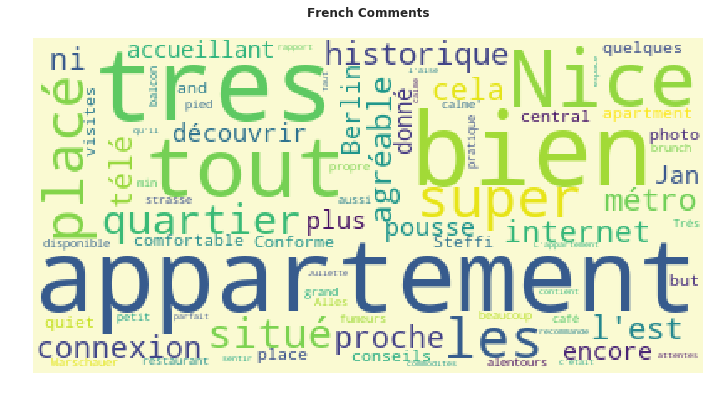

In [17]:
wordcloud = WordCloud(max_font_size=100, max_words=150, background_color="lightgoldenrodyellow",
                      stopwords = stopwords.words('french')).generate(str(df_fr.comments.values))

plot_wordcloud(wordcloud, 'French')

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 4. Sentiment Analysis
<a id='4. Sentiment Analysis'></a>

An excellent and easy-to-read overview of sentiment analysis and the VADER package can be found on Jodie Burchell's <a href='http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html'> blogpost</a>. (I don't want to repeat what she worded so I rather recommend reading her own words.)

In [18]:
# load the SentimentIntensityAnalyser object in
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [20]:
# assign it to another name to make it easier to use
analyzer = SentimentIntensityAnalyzer()

In [21]:
# use the polarity_scores() method to get the sentiment metrics
def print_sentiment_scores(sentence):
    snt = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(snt)))

VADER belongs to a type of sentiment analysis that is based on lexicons of sentiment-related words. In this approach, each of the words in the lexicon is rated as to whether it is positive or negative, and in many cases, how positive or negative.

Let's play around a bit:

In [30]:
print_sentiment_scores("This raspberry cake is good.")

This raspberry cake is good.------------ {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}


VADER produces four sentiment metrics from these word ratings, which you can see above. The first three, positive, neutral and negative, represent the proportion of the text that falls into those categories. As you can see, our example sentence was rated as 42% positive, 58% neutral and 0% negative. 

The final metric, **the compound score**, is the sum of all of the lexicon ratings which have been standardised to range between -1 and 1. In this case, our example sentence has a rating of 0.44, which is pretty neutral.

In [34]:
print_sentiment_scores("This raspberry cake is good.")
print_sentiment_scores("This raspberry cake is GOOD!")
print_sentiment_scores("This raspberry cake is VERY GOOD!!")
print_sentiment_scores("This raspberry cake is really GOOD! But the coffee is dreadful.")

This raspberry cake is good.------------ {'neg': 0.0, 'neu': 0.58, 'pos': 0.42, 'compound': 0.4404}
This raspberry cake is GOOD!------------ {'neg': 0.0, 'neu': 0.505, 'pos': 0.495, 'compound': 0.6027}
This raspberry cake is VERY GOOD!!------ {'neg': 0.0, 'neu': 0.488, 'pos': 0.512, 'compound': 0.7386}
This raspberry cake is really GOOD! But the coffee is dreadful. {'neg': 0.18, 'neu': 0.558, 'pos': 0.262, 'compound': 0.3222}


In [24]:
# getting only the compound score
def compound_score(text):
    compound_value = analyzer.polarity_scores(text)['compound']
    return compound_value

In [25]:
compound_score("The food is really GOOD! But the service is dreadful.")

0.3222

In [26]:
start = datetime.datetime.now()

df_eng['compound_sentiment'] = df_eng['comments'].apply(compound_score)

finish = datetime.datetime.now()
elapsed = finish - start
print('Time Elapsed:', elapsed)

Time Elapsed: 0:03:49.567976


In [27]:
df_eng.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments,neighbourhood_group,host_id,latitude,longitude,number_of_reviews,property_type,language,compound_sentiment
1,2015,69990732,2016-04-15,41944715,Hannah,Jan was very friendly and welcoming host! The ...,Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.9703
3,2015,73819566,2016-05-10,63697857,Judy,"It is really nice area, food, park, transport ...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.7955
6,2015,76603178,2016-05-28,29323516,Laurent,"We had a very nice stay in Berlin, thanks to J...",Mitte,2217,52.534537,13.402557,118,Guesthouse,en,0.9779


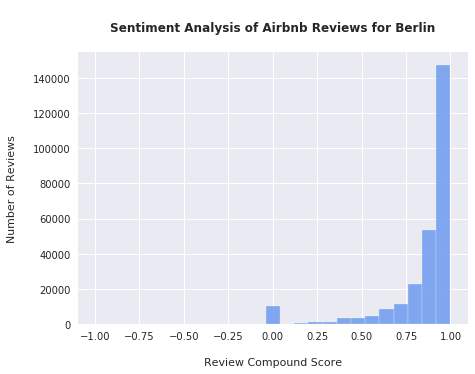

In [53]:
df_eng.hist('compound_sentiment', bins=25, color='cornflowerblue',  alpha=0.8, figsize=(7,5))
plt.title('\nSentiment Analysis of Airbnb Reviews for Berlin\n', fontsize=12, fontweight='bold')
#plt.legend(['Reviews on Berlin'])
plt.xlabel('\nReview Compound Score')
plt.ylabel('Number of Reviews\n');

In [54]:
df_eng.compound_sentiment.describe()

count    271836.000000
mean          0.831619
std           0.261954
min          -0.996800
25%           0.831300
50%           0.928700
75%           0.966700
max           0.999500
Name: compound_sentiment, dtype: float64

*Back to: <a href='#Table of contents'> Table of contents</a>*
### 6. Appendix 
<a id='6. Appendix'></a>

Data
- Inside Airbnb http://insideairbnb.com/get-the-data.html

WordClouds
- https://vprusso.github.io/blog/2018/natural-language-processing-python-3/
- https://www.datacamp.com/community/tutorials/wordcloud-python

Bar Charts
- http://robertmitchellv.com/blog-bar-chart-annotations-pandas-mpl.html

Language Detection
- TextBlob:
    - https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/
    - https://github.com/shubhamjn1/TextBlob/blob/master/Textblob.ipynb
    - https://stackoverflow.com/questions/43485469/apply-textblob-in-for-each-row-of-a-dataframe
    - https://textblob.readthedocs.io/en/dev/quickstart.html

- Spacy:
    - https://github.com/nickdavidhaynes/spacy-cld
    - https://spacy.io/usage/models

- Langdetect & LangId:
    - https://pypi.org/project/langdetect/ 
    - https://www.probytes.net/blog/python-language-detection/
    - https://github.com/hb20007/hands-on-nltk-tutorial/blob/master/8-1-The-langdetect-and-langid-Libraries.ipynb

Sentiment Analysis
- http://t-redactyl.io/blog/2017/04/using-vader-to-handle-sentiment-analysis-with-social-media-text.html
- https://towardsdatascience.com/digging-into-airbnb-data-reviews-sentiments-superhosts-and-prices-prediction-part1-6c80ccb26c6a
- https://medium.com/@mauriziosantamicone/seattle-confidential-unpacking-airbnb-reviews-with-sentiment-d421c15d8b8f
- http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf

Eventuell für später
- !!!!!https://data-viz-for-fun.com/2018/08/airbnb-data-viz/